In [1]:
# matplotlib inline plotting
%matplotlib inline
# make inline plotting higher resolution
%config InlineBackend.figure_format = 'svg'

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re
from sklearn.ensemble import RandomForestClassifier
from statsmodels.api import OLS
from statsmodels.api import add_constant

plt.style.use('dark_background')

## Kaggle Knowledge Competition: Titanic - Machine Learning from Disaster

My solution attempt at predicting which passengers survived the Titanic shipwreck.

Data and additional information is available at [Kaggle](https://www.kaggle.com/c/titanic)

### 1: Read data

In [3]:
train = pd.read_csv('train.csv', index_col='PassengerId')
train.index.name = None
train.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [4]:
test = pd.read_csv('test.csv', index_col='PassengerId')
test.index.name = None
test.head()

,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [5]:
# I will need to do the same operations for each data-set - thus combining them in an iterable list.
combined = [train, test]

### 2: Missing Data

#### 2.1 Cabin is missing
There's so few observations on the `Cabin` column. I'll drop this one.

In [6]:
print(f'{train.Cabin.shape[0] - train.Cabin.dropna().shape[0]} missing observations for Cabin.')

for df in combined:
    df.drop(columns='Cabin', inplace=True)

687 missing observations for Cabin.


#### 2.2 Age has a lot of missing observations
There's a lot of missing observations on `Age`. This is however not as severe as for the `Cabin` column.

I think we can use the cross-section, taking into account number of siblings/parents etc. to fill these `NaN`s using OLS.

This poses a few issues however:
- The $R^2$ of the regressions are relatively low. However one can reasonable assume that this method is more exact than filling based on median/averages.
- The models are however significant (joint f-test).
- OLS can predict negative ages. For any here I'll assume that they're babies and fix age at 1. I also fix ages as integer to stay consistent with existing data.

In [7]:
for df in combined:
    # train-data
    X_train = df.loc[df['Age'].dropna().index]
    X_train = X_train.dropna(how='any')
    X_train = add_constant(X_train)
    
    Y_train = X_train['Age']
    
    X_train = X_train.drop(columns=['Name', 'Age', 'Ticket'])
    X_train = pd.get_dummies(X_train, drop_first=True)  # one-hot encoding

    # test-data
    X_test = df.loc[df['Age'].isnull()]
    X_test = add_constant(X_test)
    
    Y_test = X_test['Age']

    X_test = X_test.drop(columns=['Name', 'Age', 'Ticket'])
    X_test = pd.get_dummies(X_test, drop_first=True)  # one-hot encoding
    
    mdl = OLS(endog=Y_train, exog=X_train)
    mdl = mdl.fit()
    
    # Predict and fill age data from OLS model
    fillData = mdl.predict(X_test)
    df['Age'].fillna(fillData, inplace=True)
    
    print(f'Dataset has {df.shape[0] - X_train.shape[0]} missing values.')
    print(f'OLS R2: {np.round(mdl.rsquared, 2)}, Joint f-statistic: {np.round(mdl.fvalue, 2)}')
    print('\n')

Dataset has 179 missing values.
OLS R2: 0.27, Joint f-statistic: 33.0


Dataset has 87 missing values.
OLS R2: 0.28, Joint f-statistic: 17.78




In [8]:
# OLS can predict non-integer and negative ages
for df in combined:
    df['Age'] = df['Age'].apply(np.round)
    df['Age'] = df['Age'].apply(lambda x: 1 if x < 1 else x)

#### 2.3 Last NaN's in `Embarked` and `Fare`
These values are so rare and sparse that I'll simply fill with most likely observation.

In [9]:
for df in combined:
    df['Fare'].fillna(df['Fare'].mean(), inplace=True)
    df['Embarked'].fillna(df['Embarked'].value_counts().sort_values().index[-1], inplace=True)

### 3: Feature Engineering

Now that we've dealt with all missing values, it is time to scale and engineer our values for our `RandomForrest` model.

The goal here is to extract as much information as possible from the supplied data.

#### 3.1 There's more to a name

To be able to distinguish the passengers in more sub-categories, we'll use the title in their name. There's probably a lot more to be done here - fx. looking at the ethnicity of passengers based on their names. We'll keep it simple for now though.

As we see, there's a lot of _less-frequent_ titles. I'll bulk these into `Royal` or `Professional` depending on their role in society.

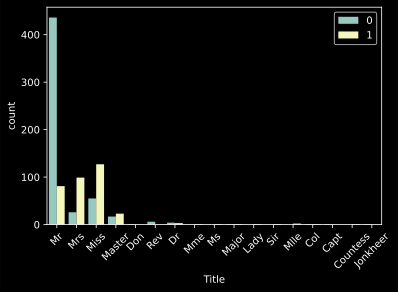

In [10]:
for df in combined:
    df['Title'] = df['Name'].apply(lambda x: re.search(string=x, pattern=' ([A-Z][a-z]+)\.').group(1))

sns.countplot(data=train, x='Title', hue='Survived')
plt.xticks(rotation=45)
plt.legend(loc='upper right')
plt.show()

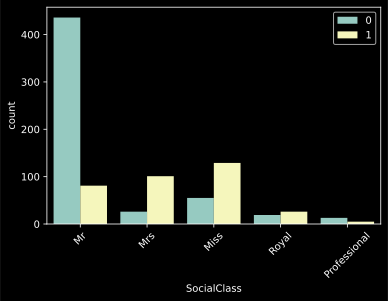

In [11]:
SocialClass = {'Mr': 'Mr',
               'Mrs': 'Mrs',
               'Miss': 'Miss',
               'Master': 'Royal',
               'Don': 'Royal',
               'Rev': 'Professional',
               'Dr': 'Professional',
               'Mme': 'Mrs',
               'Ms': 'Mrs',
               'Major': 'Professional',
               'Lady': 'Royal',
               'Sir': 'Royal',
               'Mlle': 'Miss',
               'Col': 'Professional',
               'Capt': 'Professional',
               'Countess': 'Royal',
               'Jonkheer': 'Royal'}

for df in combined:
    df['SocialClass'] = df['Title'].map(SocialClass)
    
sns.countplot(data=train, x='SocialClass', hue='Survived')
plt.xticks(rotation=45)
plt.legend(loc='upper right')
plt.show()

#### 3.2 Families who travel together, survive together (?!)

One could reasonable assume, that larger families would stick together and possible be able to secure a lifeboat together. To investigate this, I'll create a `FamSize` feature consisting of `SibSp + Parch + 1`. This feature will of cause overlap across the data.

- We see in the plot that there tends to be higher survivability for family-sizes from 2-4. 

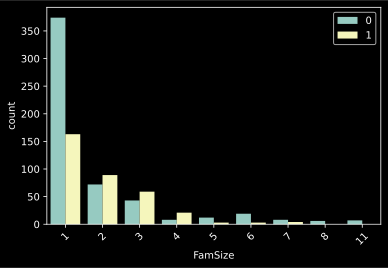

In [12]:
for df in combined:
    df['FamSize'] = df['SibSp'] + df['Parch'] + 1
    
sns.countplot(data=train, x='FamSize', hue='Survived')
plt.xticks(rotation=45)
plt.legend(loc='upper right')
plt.show()

#### 3.3 Old and young of the boat!

We see in the density, that there are _some_ differences in terms of whom survives depending on age.

To better explain this variation we'll group passengers into age groups.

- There is probably some intuition behind this result. Passengers in the group 20-30 would likely have been either staff (very likely) or somehow wealthy. 

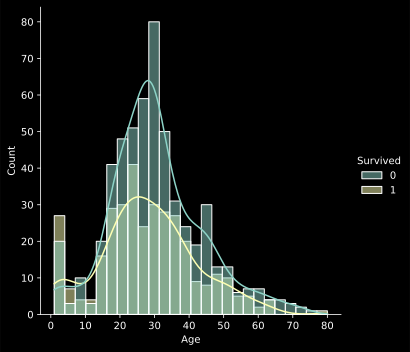

In [13]:
sns.displot(x='Age', hue='Survived', data=train, kde=True)
plt.show()

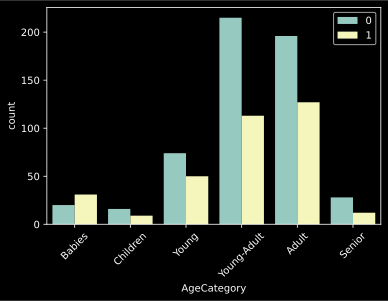

In [14]:
intervals = [0, 5, 12, 20, 30, 55, 120]
category = ['Babies', 'Children', 'Young', 'Young-Adult', 'Adult', 'Senior']

for df in combined:
    df['AgeCategory'] = pd.cut(df['Age'], intervals, labels=category)
    
    
sns.countplot(data=train, x='AgeCategory', hue='Survived')
plt.xticks(rotation=45)
plt.legend(loc='upper right')
plt.show()

#### 3.4 Even rich people are mortal

This is probably the saddest graph in this notebook. However we see a very strong trend that survivability increases with ticket-price.

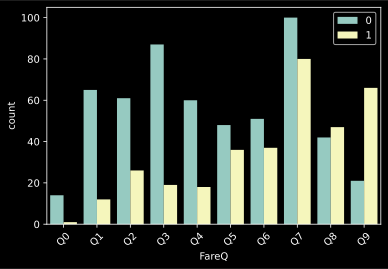

In [15]:
for df in combined:
    intervals = [
        -1,
        1,
        np.quantile(df['Fare'], q=.10),
        np.quantile(df['Fare'], q=.20),
        np.quantile(df['Fare'], q=.30),
        np.quantile(df['Fare'], q=.40),
        np.quantile(df['Fare'], q=.50),
        np.quantile(df['Fare'], q=.60),
        np.quantile(df['Fare'], q=.80),
        np.quantile(df['Fare'], q=.90),
        np.quantile(df['Fare'], q=1) +1
    ]
    category = [f'Q{i}' for i in range(len(intervals) -1)]

    df['FareQ'] = pd.cut(df['Fare'], intervals, labels=category)
    
sns.countplot(data=train, x='FareQ', hue='Survived')
plt.xticks(rotation=45)
plt.legend(loc='upper right')
plt.show()

### 4: Drop and encode datasets

In [16]:
# drop irrelevant columns
for df in combined:
    df = df.drop(columns=['Name', 'Ticket', 'Fare', 'Age', 'Title'], inplace=True)

In [17]:
# use one-hot encoding
train = pd.get_dummies(train, drop_first=True)
test = pd.get_dummies(test, drop_first=True)

In [18]:
X_train = train.drop(columns='Survived')
Y_train = train['Survived']
X_test = test

### 5: Model fit and prediction

In [19]:
mdl = RandomForestClassifier()
mdl.fit(X_train, Y_train)
Y_pred = mdl.predict(X_test)
print(f'RandomForest cross-validation score: {np.round(mdl.score(X_train, Y_train), 4) * 100}%')

RandomForest cross-validation score: 90.68%


In [20]:
pd.DataFrame({'PassengerId': test.index, 'Survived': Y_pred}).to_csv('submission.csv', index=False)